In [1]:
#imports
import os
import numpy as np
from nilearn import plotting, image
import pandas as pd
import hcp_utils as hcp
import nilearn.connectome as nic
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from imblearn.combine import SMOTEENN

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [2]:
file_path  = '/home/anmarkova/teams/a05/group_2/parcellations'
sub_list = os.listdir(file_path)
mmp = {}
ca = {}
sub_ids_mmp = []
sub_ids_ca = []
for i in sub_list:
    if 'mmp' in i:
        mmp_file = np.load(file_path+'/'+i)
        if mmp_file.shape == (3600, 379):
            key = int(re.search(r"sub-(\d+)", i).group(1))
            mmp[key] = mmp_file
    if 'ca' in i:
        ca_file = np.load(file_path+'/'+i)
        if ca_file.shape == (3600, 718):
            key = int(re.search(r"sub-(\d+)", i).group(1))
            ca[key] = ca_file

In [3]:
df = pd.read_csv('/home/anmarkova/teams/a05/group_2/handedness_data.csv')

In [4]:
df[df['Handedness'] < 0]

,Subject,Handedness
10,192641,-35
13,214524,-35
37,200614,-70
42,898176,-5
66,125525,-100
78,164636,-80
96,200210,-5
98,899885,-40
121,249947,-100
123,283543,-55


In [5]:
ca_data = np.array(list(ca.values()))

In [6]:
ca_data.shape

(172, 3600, 718)

In [7]:
mmp_data = np.array(list(mmp.values()))

In [8]:
mmp_data.shape

(172, 3600, 379)

## MMP Data

In [9]:
#Correlation matrix
correlation_measure = nic.ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform(mmp_data)

In [10]:
#replace 1.0 with 0.999 correlations
correlation_matrix[correlation_matrix == 1.00] = np.nan

In [11]:
fisher_z_matrices = np.arctanh(correlation_matrix)

In [12]:
labels = list(hcp.mmp.labels.values())[1:]

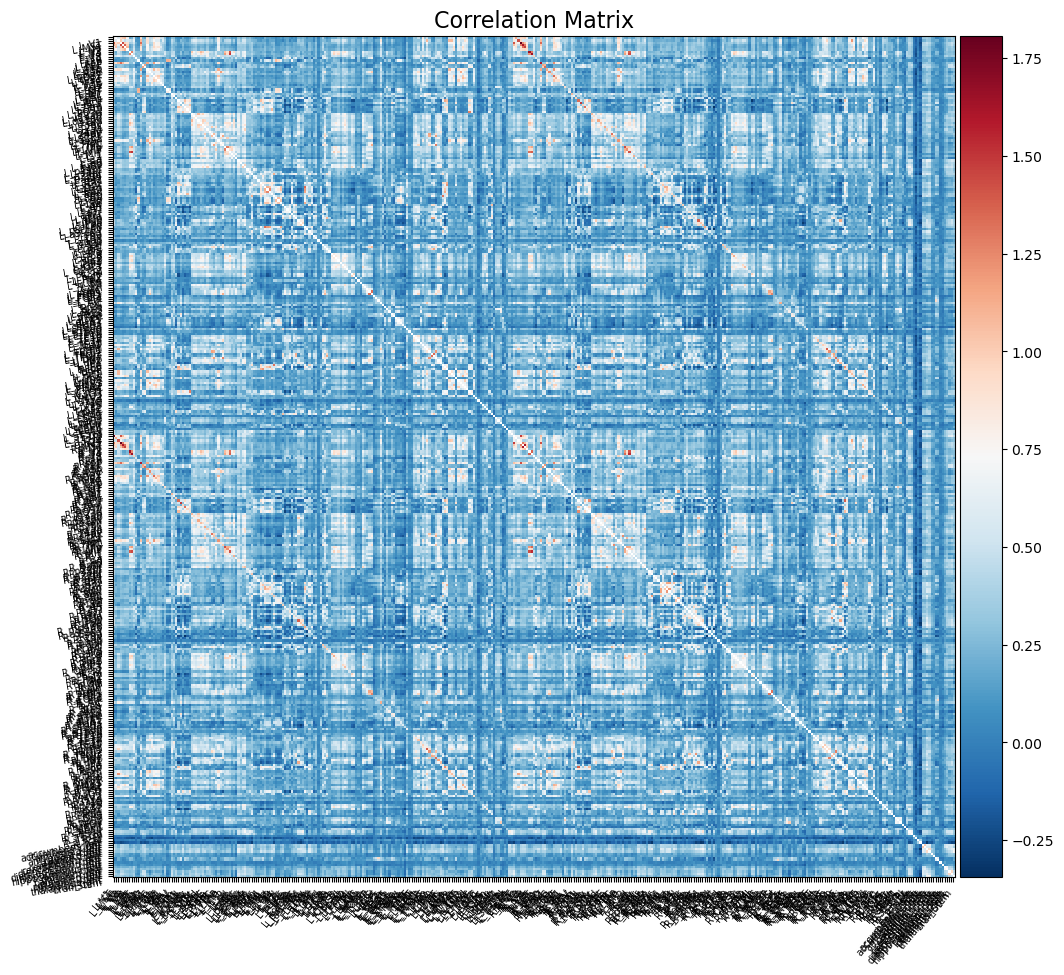

In [13]:
fig, ax = plt.subplots(figsize=(10, 10),
                       layout='constrained')
plotting.plot_matrix(fisher_z_matrices[0], title='Correlation Matrix', labels= labels, colorbar = True, figure=fig)

In [14]:
corr_dict = {}
for i in range(len(labels)):
    for j in range(len(labels)):
        if not i == j:
            val = np.corrcoef(fisher_z_matrices[:, i, j], df['Handedness'])
            corr_dict[(i, j)] = val[0, 1]

(array([9.2000e+01, 1.1260e+03, 7.4260e+03, 2.5436e+04, 4.5202e+04,
        4.0718e+04, 1.8410e+04, 4.3200e+03, 4.9800e+02, 3.4000e+01]),
 array([-0.21969858, -0.16833357, -0.11696856, -0.06560355, -0.01423854,
         0.03712647,  0.08849147,  0.13985648,  0.19122149,  0.2425865 ,
         0.29395151]),
 <BarContainer object of 10 artists>)

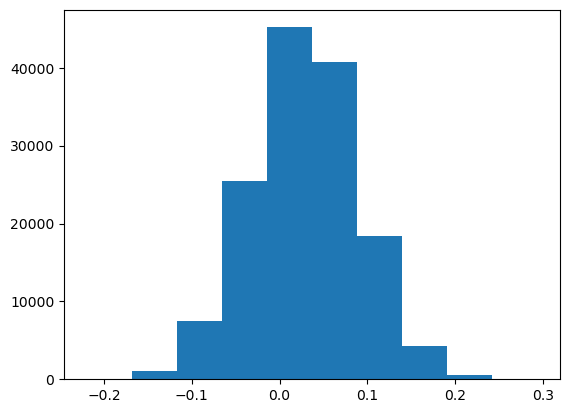

In [16]:
corr_dict
plt.hist(list(corr_dict.values()))

## top 5%

In [25]:
np.percentile(np.array(list(corr_dict.values())), 0.005)

np.float64(-0.20346918262327174)

In [37]:
top_5 = {k: v for k, v in corr_dict.items() if abs(v) > 0.2}
max(list(top_5.items()), key=lambda x:x[1])

((127, 214), np.float64(0.2939515114248714))

## Plot top correlations

In [48]:
df['Binary'] = df['Handedness'] > 0
df['c'] = df['Binary'].replace(True, 'r')
df['c'] = df['c'].replace(False, 'b')

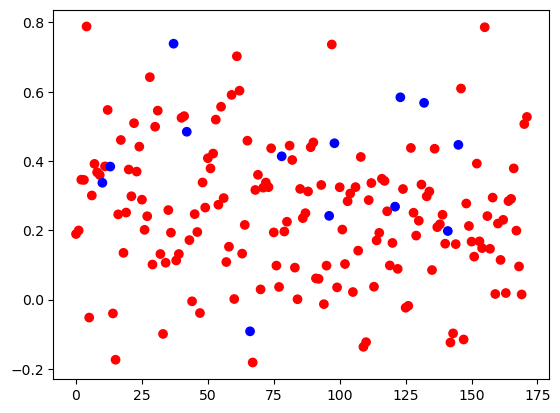

In [61]:
plt.scatter(range(len(fisher_z_matrices)), fisher_z_matrices[:, 69, 170], color=df['c'])

### Non-Fisher Matrices

In [63]:
corr_dict = {}
for i in range(len(labels)):
    for j in range(len(labels)):
        if not i == j:
            val = np.corrcoef(correlation_matrix[:, i, j], df['Handedness'])
            corr_dict[(i, j)] = val[0, 1]

(array([1.0200e+02, 1.3840e+03, 8.8460e+03, 2.7966e+04, 4.6086e+04,
        3.8446e+04, 1.6232e+04, 3.7440e+03, 4.2200e+02, 3.4000e+01]),
 array([-0.217902  , -0.16606972, -0.11423745, -0.06240517, -0.0105729 ,
         0.04125938,  0.09309165,  0.14492393,  0.19675621,  0.24858848,
         0.30042076]),
 <BarContainer object of 10 artists>)

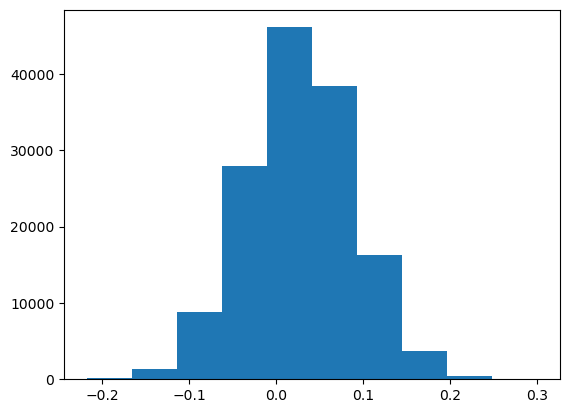

In [64]:
corr_dict
plt.hist(list(corr_dict.values()))

Try Variance

## CA Data

In [65]:
#Correlation matrix
correlation_measure = nic.ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform(ca_data)

In [66]:
#replace 1.0 with 0.999 correlations
correlation_matrix[correlation_matrix == 1.00] = 0

In [67]:
fisher_z_matrices = np.arctanh(correlation_matrix)

In [117]:
#hcp.ca_parcels.labels

In [68]:
labels = list(hcp.ca_parcels.labels.values())[1:]

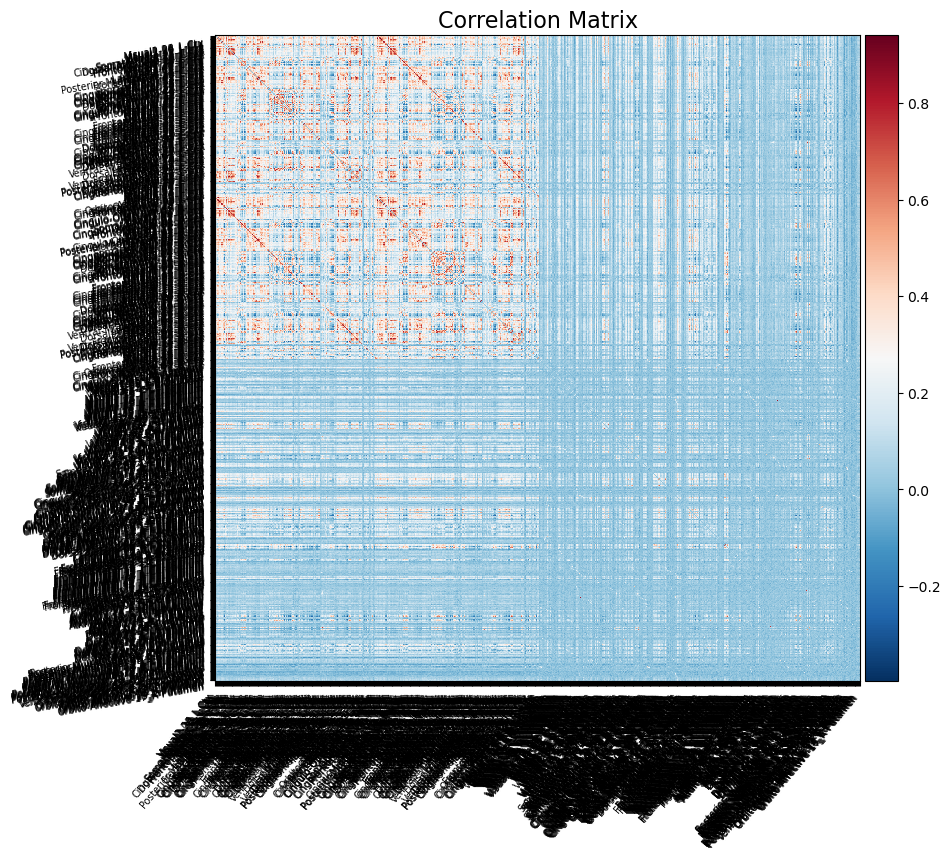

In [69]:
fig, ax = plt.subplots(figsize=(10, 10),
                       layout='constrained')
plotting.plot_matrix(correlation_matrix[13], title='Correlation Matrix', labels= labels, colorbar = True, figure=fig)

### Extracting Features

In [70]:
corr_dict = {}
for i in range(len(labels)):
    for j in range(len(labels)):
        if not i == j:
            val = np.corrcoef(correlation_matrix[:, i, j], df['Handedness'])
            corr_dict[(i, j)] = val[0, 1]

In [77]:
np.percentile(np.array(list(corr_dict.values())), 0.005)

np.float64(-0.2751065260229404)

In [78]:
top_5 = {k: v for k, v in corr_dict.items() if abs(v) > 0.25}
max(list(top_5.items()), key=lambda x:x[1])

((549, 618), np.float64(0.32535372609719027))

(array([86.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 24., 18.]),
 array([-0.30542298, -0.24234531, -0.17926764, -0.11618997, -0.0531123 ,
         0.00996537,  0.07304304,  0.13612071,  0.19919838,  0.26227606,
         0.32535373]),
 <BarContainer object of 10 artists>)

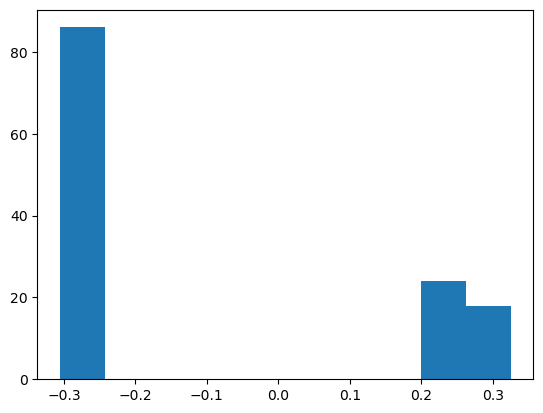

In [79]:
plt.hist(list(top_5.values()))

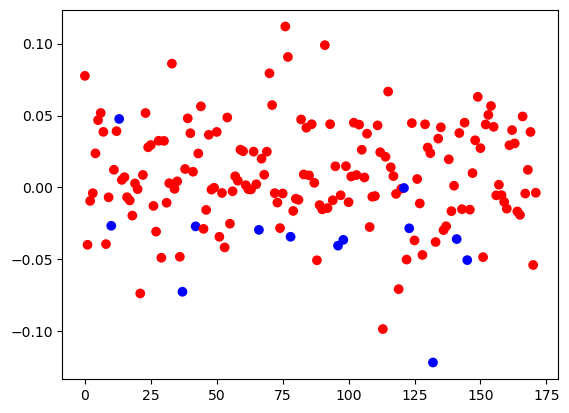

In [80]:
plt.scatter(range(len(fisher_z_matrices)), fisher_z_matrices[:, 549, 618], color=df['c'])

## Prediction

In [165]:
#np.where(labels)
idx_motor = [i for i in range(len(labels)) if 'motor' in str(labels[i]).lower()] 

In [181]:
#extract the top corner of correlation matrix
X = []
for i in range(len(correlation_matrix)):
    
    top_triangle = np.triu(correlation_matrix[0], -1)
    # no_zeros = top_triangle[top_triangle != 0] but what if some correlations are zero? i feel like i can't just cut them out like this
    


In [196]:
X = np.triu(correlation_matrix, -1)
X = np.reshape(X, (172, -1))
y = df['Handedness']

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

In [216]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)

In [217]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

In [205]:
regressor = DecisionTreeRegressor(max_depth = 10)

In [206]:
cross_val_score(regressor, X, y, cv=10)

KeyboardInterrupt: 

In [218]:
regressor.fit(X_res, y_res)

DecisionTreeRegressor(max_depth=10)

In [226]:
y_pred = regressor.predict(X_test)

In [227]:
print('Accuracy', sum(y_test == y_pred)/len(y_test))

Accuracy 0.13953488372093023


Text(0, 0.5, 'y_pred')

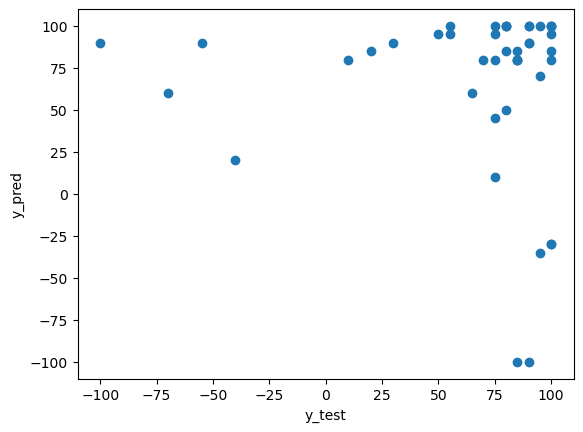

In [228]:
plt.scatter(y_test, y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')

In [231]:
from sklearn.linear_model import Ridge, SGDRegressor
linear_regressor = SGDRegressor()
linear_regressor.fit(X_res, y_res)

SGDRegressor()

In [232]:
y_pred = linear_regressor.predict(X_test)

Text(0, 0.5, 'y_pred')

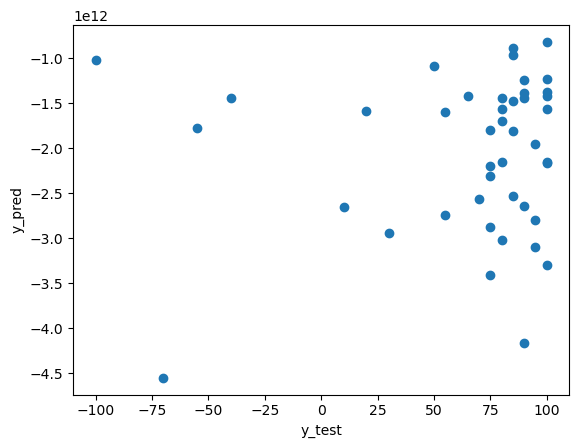

In [233]:
plt.scatter(y_test, y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')

## No idea how to find points that are close to our rois

In [154]:
def euclidean(point1, point2):
    distance = 0
    for i in range(len(point1)-1):
        distance += (point1[i] - point2[i]) ** 2
    return (distance) ** 0.5

In [155]:
def find_closest_point(atlas_coords, reference_point):
    dist = np.inf
    closest_idx = None
    points=[]
    for idx in range(len(atlas_coords)):
        i = atlas_coords[idx]
        curr_dist = euclidean(reference_point, i)
        if curr_dist < dist:
            dist = curr_dist
            closest_point = i
            closest_idx = idx
    print(dist, closest_point)
    return closest_idx

In [156]:
rois = {
    "Left M1": [-38, -24, 62],
    "Right M1": [34, -22, 62],
    "Left SMA" : [-8, 0, 54],
    "Right SMA" : [8, 0, 54],
    "Left PMd": [-16, -20, 48],
    "Right PMd": [34, -8, 52]}

In [158]:
mni_coordinates

,Region,MNI_x,MNI_y,MNI_z
0,1,-10.078265,-84.159427,1.758543
1,2,-44.735516,-67.289673,11.761965
2,3,-15.101997,-79.082739,30.835949
3,4,-12.044036,-82.059170,4.029322
4,5,-16.606670,-84.793414,7.258655
...,...,...,...,...
355,356,54.773684,-10.771053,-15.707895
356,357,64.920093,-24.603675,-15.518810
357,358,44.447070,-2.377127,-13.536862
358,359,9.604651,28.588551,30.208408


In [5]:
atlas_path = "/home/anmarkova/teams/a05/group_2/MNI_Glasser_HCP_v1.0.nii.gz"
atlas = image.load_img(atlas_path)
atlas = image.threshold_img(atlas, "99.5%") 

print("atlas has shape", ["x", "y", "z", "region"], "=", atlas.shape)

/tmp/ipykernel_421/1708466197.py:3: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  atlas = image.threshold_img(atlas, "99.5%")


atlas has shape ['x', 'y', 'z', 'region'] = (256, 256, 256)


SyntaxError: 'return' outside function (1708466197.py, line 6)

In [8]:
get_atlas_coords(atlas)

DimensionError: Input data has incompatible dimensionality: Expected dimension is 4D and you provided a 3D image. See https://nilearn.github.io/stable/manipulating_images/input_output.html.

In [157]:
all_points = set()
for k, v in rois.items():
    print(f"Closest point to {k}:")
    closest = find_closest_point(mni_coordinates, v)
    all_points.add(closest)

Closest point to Left M1:


KeyError: 0

TypeError: Data given cannot be loaded because it is not compatible with nibabel format:
np.float64(-10.078...

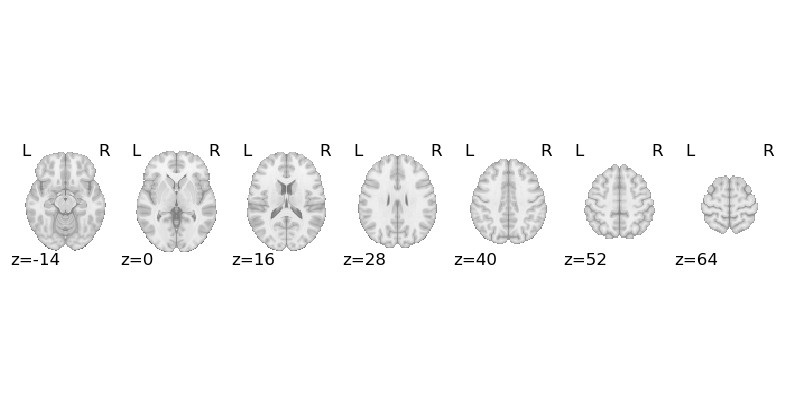

In [161]:
fig, axs = plt.subplots(nrows=1, figsize=(10, 5))
# selected_regions = image.index_img(atlas, list(all_points))
plotting.plot_prob_atlas(coords, colorbar=True, draw_cross=False, axes=axs, display_mode="z")
axs.set_title("Map of Brain Regions")

In [46]:
hcp.mmp.map_all

array([ 35,  52,  12, ..., 378, 378, 378], shape=(91282,))

In [50]:
hcp.view_parcellation(sub_data[0])

TypeError: view_parcellation() missing 1 required positional argument: 'parcellation'

In [58]:
#loading atlas parcelations
def load_atlas(file_path=None):
    '''
    loads txt data of all subjects

    params:
    n (int): number of brain regions options: 15, 50, 100; 100 by default
    file_path: your own filepath

    return:
    all data (np.array): 
    '''
    if not file_path:
        file_path = f"/home/anmarkova/teams/a05/group_2/HCP_PTN1200/groupICA/groupICA_3T_HCP1200_MSMAll_d{n}.ica/melodic_IC_sum.nii.gz"
    atlas = image.load_img(file_path)
    atlas = image.threshold_img(atlas, "99.5%") 

    print("atlas has shape", ["x", "y", "z", "region"], "=", atlas.shape)
    return atlas

In [60]:
atlas = load_atlas('/home/anmarkova/teams/a05/group_2/MNI_Glasser_HCP_v1.0.nii.gz')

/tmp/ipykernel_581/3615962180.py:16: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  atlas = image.threshold_img(atlas, "99.5%")


atlas has shape ['x', 'y', 'z', 'region'] = (256, 256, 256)


In [7]:
def get_atlas_coords(atlas):
    #plotting connections on the brain
    atlas_coords = plotting.find_probabilistic_atlas_cut_coords(atlas)
    atlas_coords = np.array(atlas_coords)
    return atlas_coords

In [64]:
get_atlas_coords(atlas)

DimensionError: Input data has incompatible dimensionality: Expected dimension is 4D and you provided a 3D image. See https://nilearn.github.io/stable/manipulating_images/input_output.html.

In [ ]:
import nibabel as nib
import numpy as np
import pandas as pd
from scipy.ndimage import center_of_mass

def extract_mni_coordinates(atlas_path):
    """ Extracts the center of mass MNI coordinates for each parcel in an atlas. """
    # Load atlas
    atlas_img = nib.load(atlas_path)
    atlas_data = atlas_img.get_fdata()
    affine = atlas_img.affine  # Affine matrix to convert voxel to MNI

    # Get unique regions (excluding 0, which is background)
    regions = np.unique(atlas_data)
    regions = regions[regions > 0]  # Remove background

    # Compute center of mass for each region
    mni_coords = {}
    for region in regions:
        coords = np.array(np.where(atlas_data == region))
        com_voxel = np.mean(coords, axis=1)  # Compute center of mass in voxel space
        com_mni = nib.affines.apply_affine(affine, com_voxel)  # Convert to MNI space
        mni_coords[int(region)] = com_mni

    # Convert to DataFrame
    df = pd.DataFrame(mni_coords).T
    df.columns = ["MNI_x", "MNI_y", "MNI_z"]
    df.index.name = "Region"
    
    return df

# Usage
atlas_path = "/home/anmarkova/teams/a05/group_2/MNI_Glasser_HCP_v1.0.nii.gz"
mni_coordinates = extract_mni_coordinates(atlas_path)
print(mni_coordinates.head())

In [135]:
mni_coordinates = mni_coordinates.reset_index()

ValueError: Invalid shape for 'node_coords'. You passed an 'adjacency_matrix' of shape (379, 379) therefore 'node_coords' should be a array with shape (379, 3) while its shape was (360, 4).

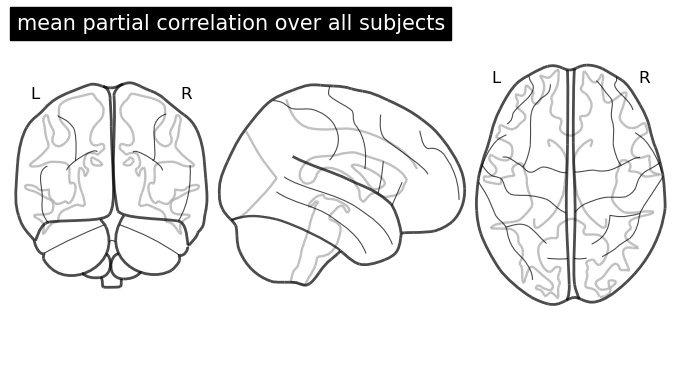

In [144]:
plotting.plot_connectome(
    correlation_measure.mean_,
    mni_coordinates,
    title="mean partial correlation over all subjects",
    edge_threshold="98%", colorbar=True
)

In [142]:
mni_coordinates['Region'] = mni_coordinates.reset_index()['index'] + 1

In [159]:
coords = mni_coordinates.loc[:, ['MNI_x', 'MNI_y', 'MNI_z', 'Region']].to_numpy()

In [160]:
coords

array([[-10.07826528, -84.15942659,   1.7585433 ,   1.        ],
       [-44.73551637, -67.28967254,  11.76196474,   2.        ],
       [-15.10199715, -79.08273894,  30.83594864,   3.        ],
       ...,
       [ 44.44706994,  -2.37712665, -13.536862  , 358.        ],
       [  9.60465116,  28.58855098,  30.20840787, 359.        ],
       [  4.87796888,  37.00737101,  15.17772318, 360.        ]],
      shape=(360, 4))

In [72]:
sub_data.shape

(172, 3600, 379)

In [74]:
hcp.mmp.ids

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [77]:
np.array(mni_coordinates.index)

array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
         12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
         23,   24,   25,   26,   27,   28,   29,   30,   31,   32,   33,
         34,   35,   36,   37,   38,   39,   40,   41,   42,   43,   44,
         45,   46,   47,   48,   49,   50,   51,   52,   53,   54,   55,
         56,   57,   58,   59,   60,   61,   62,   63,   64,   65,   66,
         67,   68,   69,   70,   71,   72,   73,   74,   75,   76,   77,
         78,   79,   80,   81,   82,   83,   84,   85,   86,   87,   88,
         89,   90,   91,   92,   93,   94,   95,   96,   97,   98,   99,
        100,  101,  102,  103,  104,  105,  106,  107,  108,  109,  110,
        111,  112,  113,  114,  115,  116,  117,  118,  119,  120,  121,
        122,  123,  124,  125,  126,  127,  128,  129,  130,  131,  132,
        133,  134,  135,  136,  137,  138,  139,  140,  141,  142,  143,
        144,  145,  146,  147,  148,  149,  150,  1